In [48]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa.display
import keras
import datetime
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif as mi


plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (10, 10
                                 ) 
plt.rcParams['axes.grid']=False
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

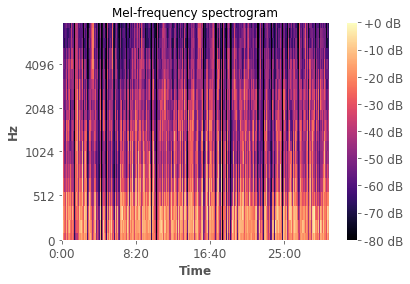

In [4]:
y,sr = librosa.load('/content/sample_data/trimmed.mov')
dur_time = librosa.get_duration(y,sr=sr)
time_sec = round(dur_time)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=20, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')
#plt.xlim(60,120)

In [5]:
start = 0 
end = time_sec 
time_series_sec = np.linspace(start,end,len(S_dB[0]))

In [7]:
data = pd.read_csv('/content/sample_data/us_election_2020_1st_presidential_debate.csv')

In [8]:
def convert_to_sec(time_string):
    time_s_list = time_string.split(':')
    if len(time_s_list)>2:
        date_time = datetime.datetime.strptime(time_string, "%H:%M:%S")
        a_timedelta = date_time - datetime.datetime(1900, 1, 1)
        seconds = a_timedelta.total_seconds()
    else:
        date_time = datetime.datetime.strptime(time_string, "%M:%S")
        a_timedelta = date_time - datetime.datetime(1900, 1, 1)
        seconds = a_timedelta.total_seconds()
    return seconds

In [9]:
minute_list = data.minute.tolist()

In [10]:
SEC_LIST = []
for t in minute_list:
    try:
        SEC_LIST.append(convert_to_sec(t))
    except:
        SEC_LIST.append(0)
for k in range(2):
    for i in range(len(SEC_LIST)-1):
        if SEC_LIST[i]==SEC_LIST[i+1]:
            SEC_LIST[i+1]=SEC_LIST[i]+1
turn_index = SEC_LIST.index(0)
to_add = SEC_LIST[turn_index-1]
for j in range(turn_index,len(SEC_LIST)):
    SEC_LIST[j]=SEC_LIST[j]+to_add
data['Seconds']=SEC_LIST

In [11]:
data.head()

speaker minute  \
0              Chris Wallace  01:20   
1              Chris Wallace  02:10   
2   Vice President Joe Biden  02:49   
3  President Donald J. Trump  02:51   
4   Vice President Joe Biden  02:51   

                                                text  Seconds  
0  Good evening from the Health Education Campus ...     80.0  
1  This debate is being conducted under health an...    130.0  
2                                How you doing, man?    169.0  
3                                 How are you doing?    171.0  
4                                          I’m well.    172.0

In [12]:
new_data = data[data.Seconds<=time_series_sec.max()]
new_data.speaker = new_data.speaker.replace({'Chris Wallace:':'Chris Wallace'})

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [13]:
max_sec = new_data.Seconds.max()

In [14]:
new_data.drop_duplicates(subset='speaker')

speaker minute  \
0              Chris Wallace  01:20   
2   Vice President Joe Biden  02:49   
3  President Donald J. Trump  02:51   

                                                text  Seconds  
0  Good evening from the Health Education Campus ...     80.0  
2                                How you doing, man?    169.0  
3                                 How are you doing?    171.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


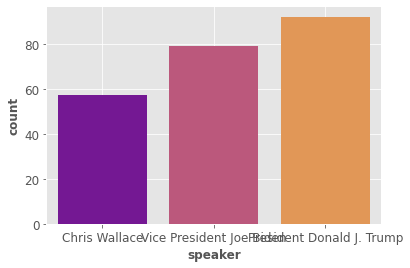

In [15]:
sns.countplot(new_data.speaker,palette='plasma')
plt.grid(True)

In [16]:
audio_data = pd.DataFrame(S_dB)
audio_data = audio_data.T
audio_data.tail()

0          1          2          3          4          5   \
77759 -15.158969 -13.466066 -14.941151 -17.230492 -19.397552 -28.687607   
77760 -16.523529 -14.244947 -15.145193 -17.768330 -19.495903 -29.107195   
77761 -18.952690 -18.976768 -20.149399 -24.263405 -26.415594 -35.300083   
77762 -25.170771 -30.229607 -35.294872 -41.173725 -40.813751 -52.013500   
77763 -39.725895 -39.369553 -41.258461 -49.926994 -52.745323 -58.144310   

              6          7          8          9          10         11  \
77759 -36.750668 -32.572224 -25.883467 -21.424074 -22.097265 -26.211336   
77760 -32.919624 -29.633957 -23.538858 -22.442219 -28.382837 -31.719610   
77761 -36.230396 -34.048878 -30.901796 -33.473690 -43.674568 -42.226318   
77762 -50.882595 -52.785564 -54.328705 -55.316772 -53.260048 -56.473701   
77763 -61.818768 -60.328186 -56.647255 -58.172024 -56.012497 -60.132130   

              12         13         14         15         16         17  \
77759 -24.228991 -30.603836 -37.822830 -35.749901 -41.598248 -40.307964   
77760 -29.222271 -34.358490 -39.945560 -45.274620 -48.393047 -45.435307   
77761 -40.130096 -46.010593 -49.413738 -58.460964 -59.073490 -57.900539   
77762 -52.522499 -60.180790 -64.927338 -65.692123 -59.329372 -63.351570   
77763 -55.594662 -63.697411 -67.403580 -66.950165 -59.855934 -63.969528   

              18         19  
77759 -41.320995 -49.900581  
77760 -45.674953 -56.438549  
77761 -57.546154 -63.397984  
77762 -66.698685 -66.779968  
77763 -68.326477 -68.767181

In [20]:
pca = PCA(n_components=4)
pca.fit(audio_data)

PCA(n_components=4)

In [21]:
pca_data = pd.DataFrame(pca.transform(audio_data))

In [22]:
audio_time = np.array(pca_data.index.tolist())*max_sec/np.array(pca_data.index.tolist()).max()
nd_time_list = [0]+new_data.Seconds.tolist()
CLASS = []
for j in range(len(audio_time)):
    time_j = audio_time[j]
    for i in range(1,len(nd_time_list)):
        start_i = nd_time_list[i-1]
        end_i = nd_time_list[i]
        if time_j>start_i and time_j<end_i:
            CLASS.append(new_data.loc[i-1].speaker)

In [23]:
pca_data['speaker']=CLASS[0:len(pca_data)]
pca_data['Time']=audio_time
pca_data.head()

0          1          2         3        speaker      Time
0  164.240738  13.372798  20.444004 -3.709286  Chris Wallace  0.000000
1  151.326263   4.258971  11.372332 -0.048594  Chris Wallace  0.022903
2  143.929169   1.075652  10.197809 -1.385319  Chris Wallace  0.045806
3  146.843048   2.860365   8.751574 -0.008709  Chris Wallace  0.068709
4  144.559021   3.930350  10.829762 -2.919458  Chris Wallace  0.091612

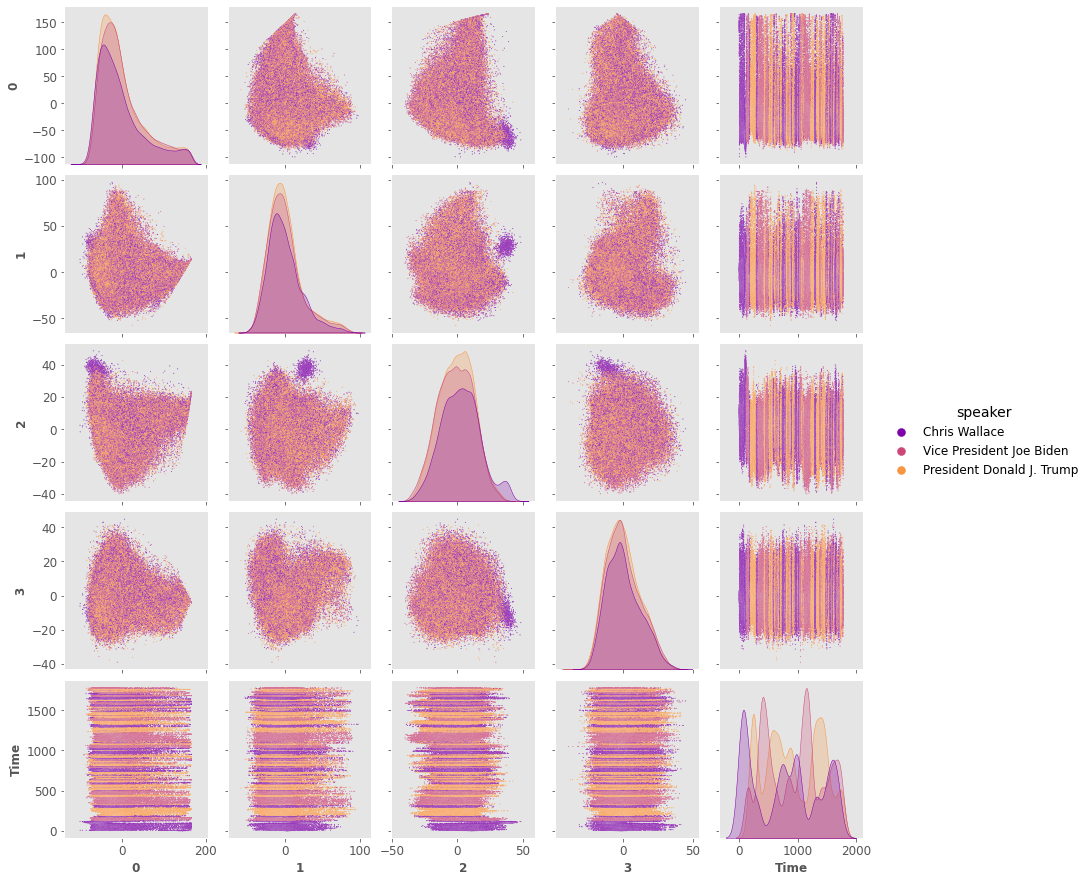

In [53]:
#plt.grid(True)
sns.pairplot(pca_data,hue='speaker',plot_kws={'s':1},palette='plasma')

In [54]:
mi(X=pca_data[['Time',0,1,2,3]],y=pca_data['speaker'])
time_series_data = pca_data[['Time',2,'speaker']]

In [55]:
time_series_data.head()

Time          2        speaker
0  0.000000  20.444004  Chris Wallace
1  0.022903  11.372332  Chris Wallace
2  0.045806  10.197809  Chris Wallace
3  0.068709   8.751574  Chris Wallace
4  0.091612  10.829762  Chris Wallace

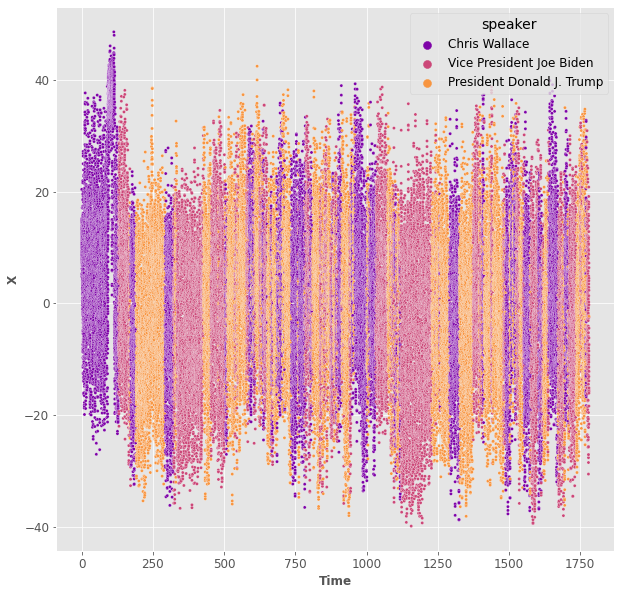

In [56]:
time_series_data = time_series_data.rename(columns={2:'X'})

sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [57]:
time_series_data['speaker']=le.fit_transform(time_series_data.speaker)


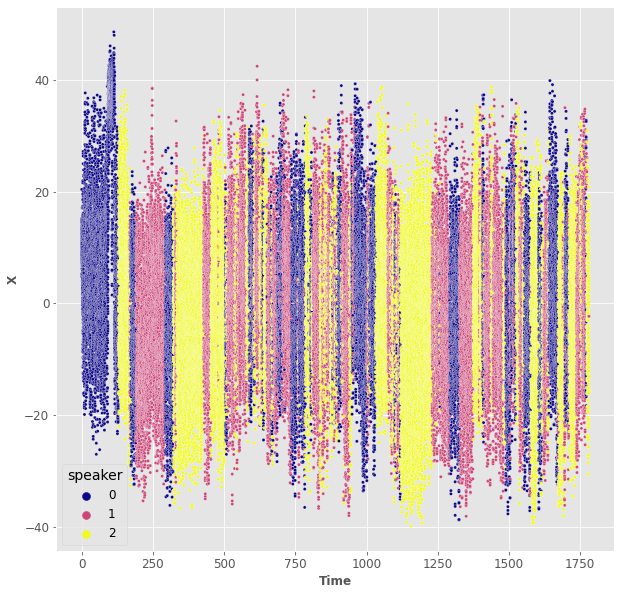

In [58]:
sns.scatterplot(x='Time',y='X',hue='speaker',data=time_series_data,s=10,palette='plasma')
plt.grid(True)

In [59]:
encod_dic = {0:'Chris Wallace',2:'Vice President Joe Biden',1:'President Donald J. Trump'}

In [60]:
X=time_series_data[['Time','X']]
y=time_series_data.speaker

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [61]:
x_train = np.array(X_train)
x_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [62]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [63]:
num_classes = len(np.unique(y_train))

In [64]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [65]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [66]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
#keras.utils.plot_model(model, show_shapes=True)

In [67]:
epochs = 30
batch_size = 50

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/30
996/996 [==============================] - 10s 8ms/step - loss: 0.9543 - sparse_categorical_accuracy: 0.5168 - val_loss: 0.8729 - val_sparse_categorical_accuracy: 0.5944 - lr: 0.0010
Epoch 2/30
996/996 [==============================] - 6s 6ms/step - loss: 0.9124 - sparse_categorical_accuracy: 0.5420 - val_loss: 0.8649 - val_sparse_categorical_accuracy: 0.5578 - lr: 0.0010
Epoch 3/30
996/996 [==============================] - 6s 6ms/step - loss: 0.8936 - sparse_categorical_accuracy: 0.5527 - val_loss: 0.8496 - val_sparse_categorical_accuracy: 0.5864 - lr: 0.0010
Epoch 4/30
996/996 [==============================] - 5s 5ms/step - loss: 0.8869 - sparse_categorical_accuracy: 0.5561 - val_loss: 0.8146 - val_sparse_categorical_accuracy: 0.6248 - lr: 0.0010
Epoch 5/30
996/996 [==============================] - 5s 5ms/step - loss: 0.8771 - sparse_categorical_accuracy: 0.5614 - val_loss: 0.8293 - val_sparse_categorical_accuracy: 0.6004 - lr: 0.0010
Epoch 6/30
996/996 [==============

In [68]:
pred_test = pd.DataFrame(model.predict(x_test))
pred_test = pred_test.rename(columns={0:encod_dic[0]})
pred_test = pred_test.rename(columns={1:encod_dic[1]})
pred_test = pred_test.rename(columns={2:encod_dic[2]})
pred_test.head()

Chris Wallace  President Donald J. Trump  Vice President Joe Biden
0       0.999409                   0.000107                  0.000484
1       0.604068                   0.336527                  0.059405
2       0.026292                   0.106985                  0.866722
3       0.017705                   0.271156                  0.711139
4       0.418006                   0.185930                  0.396064

In [69]:
test_data = X_test.reset_index().drop('index',axis=1)
test_data['target']=y_test
test_data['Chris Wallace']=pred_test['Chris Wallace']
test_data['President Donald J. Trump']=pred_test['President Donald J. Trump']
test_data['Vice President Joe Biden']=pred_test['Vice President Joe Biden']

In [70]:
target_list = test_data.target.tolist()
for t in range(len(target_list)):
    target_list[t]=encod_dic[target_list[t]]
test_data['target']=target_list
test_data = test_data.sort_values(by='Time')
test_data

Time          X                    target  Chris Wallace  \
14657     0.137418  12.776747             Chris Wallace       0.999877   
8288      0.801602  15.106977             Chris Wallace       0.999875   
5988      0.893214   5.160019             Chris Wallace       0.999878   
14417     1.236758  10.133602             Chris Wallace       0.999876   
14369     1.603205   9.517476             Chris Wallace       0.999876   
...            ...        ...                       ...            ...   
3654   1780.427427  -7.440757  Vice President Joe Biden       0.041378   
6556   1780.702262 -18.394600  Vice President Joe Biden       0.029750   
12578  1780.748068 -15.122643  Vice President Joe Biden       0.032654   
7301   1780.770971 -15.773487  Vice President Joe Biden       0.032016   
12419  1780.793874 -16.082600  Vice President Joe Biden       0.031701   

       President Donald J. Trump  Vice President Joe Biden  
14657                   0.000095                  0.000028  
8288                    0.000096                  0.000028  
5988                    0.000094                  0.000028  
14417                   0.000095                  0.000029  
14369                   0.000095                  0.000029  
...                          ...                       ...  
3654                    0.601098                  0.357524  
6556                    0.612184                  0.358066  
12578                   0.609789                  0.357556  
7301                    0.610454                  0.357531  
12419                   0.610832                  0.357467  

[15553 rows x 6 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

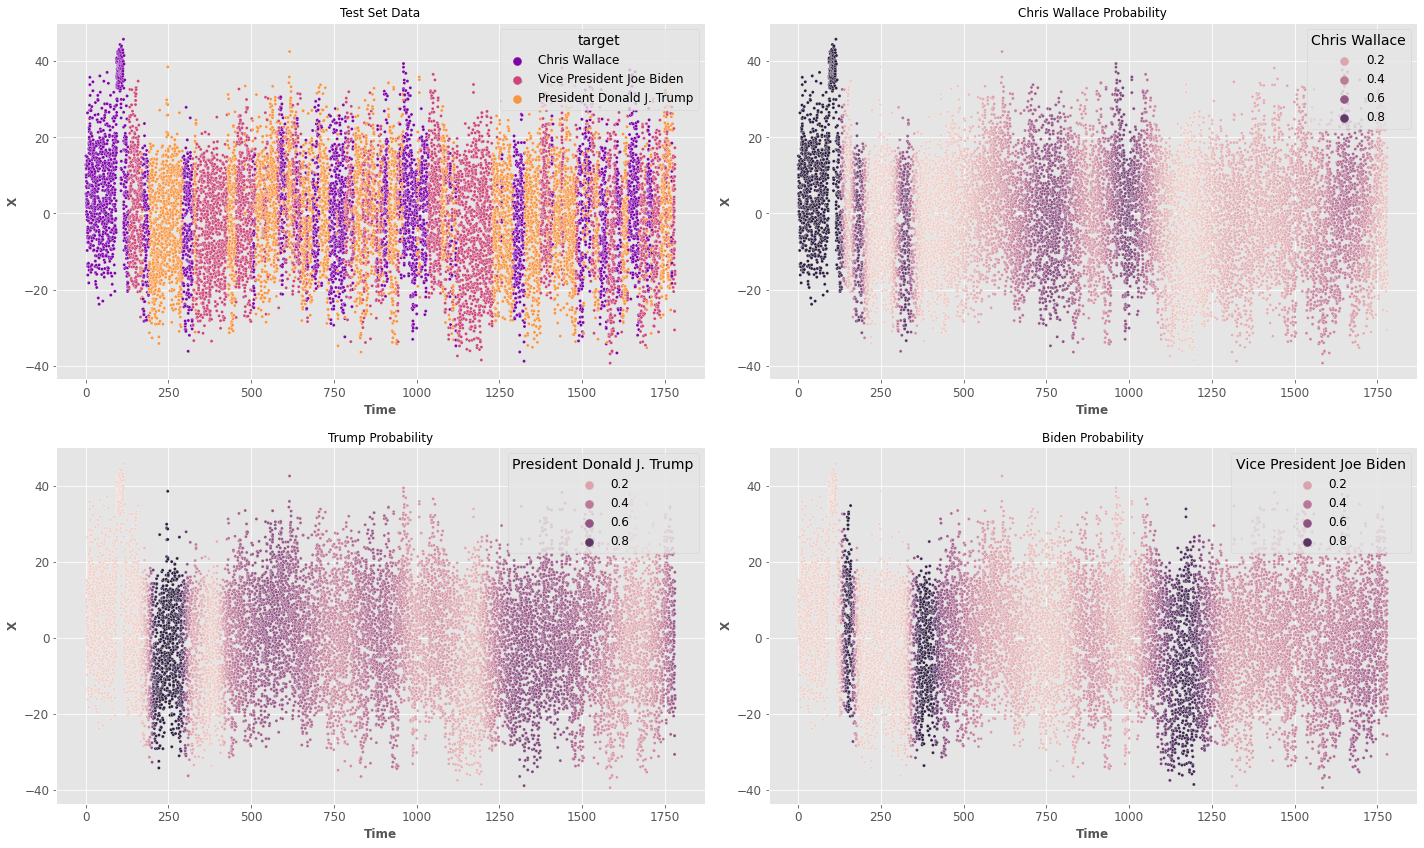

In [71]:
plt.figure(figsize=(20,12))
plt.subplot(2,2,1)
plt.title('Test Set Data')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data.target,palette='plasma')
plt.grid(True)
plt.subplot(2,2,2)
plt.title('Chris Wallace Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['Chris Wallace'])
plt.grid(True)
plt.subplot(2,2,3)
plt.title('Trump Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['President Donald J. Trump'])
plt.grid(True)
plt.subplot(2,2,4)
plt.title('Biden Probability')
sns.scatterplot(test_data.Time,test_data.X,s=10,hue=test_data['Vice President Joe Biden'])
plt.grid(True)
plt.tight_layout()

In [72]:
def model_to_clf(input_data):
    pred_list = model.predict(input_data)
    LIST_PRED = []
    for p in pred_list:
        LIST_PRED.append(np.argmax(p))
    return LIST_PRED

In [73]:
cm=confusion_matrix(model_to_clf(x_test),y_test)
cm_data = pd.DataFrame(cm,columns=[encod_dic[0],encod_dic[1],encod_dic[2]])
cm_data.index = [encod_dic[0],encod_dic[1],encod_dic[2]]
cm_data

Chris Wallace  President Donald J. Trump  \
Chris Wallace                       2932                        875   
President Donald J. Trump           1245                       3865   
Vice President Joe Biden             315                        888   

                           Vice President Joe Biden  
Chris Wallace                                   860  
President Donald J. Trump                      1545  
Vice President Joe Biden                       3028

In [74]:
cm=confusion_matrix(model_to_clf(x_test),y_test)
cm_data = pd.DataFrame(cm,columns=[encod_dic[0],encod_dic[1],encod_dic[2]])
cm_data.index = [encod_dic[0],encod_dic[1],encod_dic[2]]
cm_data

Chris Wallace  President Donald J. Trump  \
Chris Wallace                       2932                        875   
President Donald J. Trump           1245                       3865   
Vice President Joe Biden             315                        888   

                           Vice President Joe Biden  
Chris Wallace                                   860  
President Donald J. Trump                      1545  
Vice President Joe Biden                       3028

In [75]:
clf_report = classification_report(y_test,
                                   model_to_clf(x_test),
                                   labels= [0,1,2],
                                   target_names= [encod_dic[0],encod_dic[1],encod_dic[2]],
                                   output_dict=True)

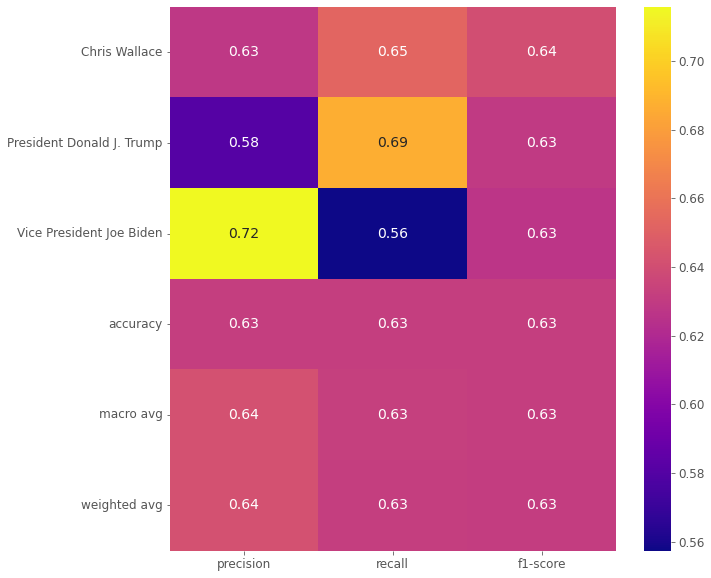

In [76]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap='plasma')